## LINE ANGLE PREDICTOR V1 - Linear Regression

### Trained with 1000 ascending random Lines, with fixed lengths, all starting at origin

In [3]:
import os
from scipy import misc
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import SGDRegressor

import math
import scipy as sc
import pickle

%matplotlib inline



## Our data set

In [4]:
folder = 'IMAGES_1000_ASCENDING'
noOfImages = 1000
dim =100 

## Utilities for feature extraction

In [5]:
def RotateImage(image, dim):
    
    new_image = np.zeros((dim, dim), dtype=np.uint8)
    new_image[:,:] = 255 
     
    # Rotate
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
            new_image[ dim - row -1,col] = image[row,  col] 

    # Copy back 
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
             image[row,  col] = new_image[row, col]

In [6]:
'''
For projecting the image on the y axis
'''
def Get_Y_Shadow(image):
    dim = 100  
    #y_shadow =  np.zeros(dim, dtype=np.uint8) 
    y_shadow =  np.full(dim,  255) 
    index= 0
    
    # Start from left col (x=0) to last col (x= 99
    for col in range(0,100): # Visit all collumns
        for row in range(0,100): 
            gray = image[row,  col]
            if  gray == 0 : # Look for non-white pixels
                # Project on y-axis
                if y_shadow[row]== 255: # Move if not was already plotted
                    index = index + 1  
                # Project on y-axis
                y_shadow[row]= col # y_shadow[row] + 1 
                 
     
    #print(index)
    # ADJUSTED index needs to be less one
    index = index -1
    
    return y_shadow,index
                    

In [7]:
'''
For projecting the image on the x axis
'''
def Get_X_Shadow(image):
    dim = 100  
    #x_shadow =  np.zeros(dim, dtype=np.uint8) 
    x_shadow =  np.full(dim,  255) 
        
    index= 0
    
    # Start from top row (y=99) to last row (y= 99
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
            gray = image[row,  col]
            if  gray == 0 : # Look for non-white pixels
                
                if x_shadow[col]== 255: # Move if not was already plotted
                    index = index + 1  
                # Project on y-axis
                x_shadow[col]= dim - 1- row #x_shadow[col] + 1 
     
    #print(index)
    
    # ADJUSTED index needs to be less one
    index = index -1
    
    return x_shadow,index
                    

In [8]:
def getFirstFromLeft(a, dim):
    for i in range(0,dim):
        if   a[i] != 255 :
            #print('From left: {}:{}'.format( i,a[i] ))
            return a[i]  

In [9]:
def getFirstFromRight(a, dim):
    for i in range(dim-1,-1,-1):
        #print(i)
        if   a[i] != 255 :
            #print('From right: {}:{}'.format( i,a[i] ))
            return a[i]  

In [10]:
def CheckIfDescends ( a, dim):
    left = getFirstFromLeft(a, dim)   
    right = getFirstFromRight(a, dim)
    
    return right < left

In [11]:
def Count(image, gray, dim): 
    c = 0
    for row in range(0,100): 
        for col in range(0,100):  
            if image[row,  col] == gray :  
                c= c+ 1 
    return c
                    

In [12]:
'''
For reducing the features, we condense the columns into one column
and the rows in one row. We will reduce and work with two features
    - yShadow
    - xShadow
'''
def ExtractImageFeatures( image, dim):
    
    # Safety check - do now work with empty images!
    # if data may have empty images enables this
    # c= Count(image, 0, 100)
    # if c== 0:
    #    print ("***EMPTY IMAGE FOUND!!!!") 
    #    return 0,0
     
 
    yShadow,dy = Get_Y_Shadow(image) 
    xShadow,dx = Get_X_Shadow(image)
 
    lineDescends = CheckIfDescends(xShadow,dim)
    if lineDescends:
        dy = -1*dy
        
    return dx,dy
    

## Create an array to store yShadow and xShadow

In [13]:
print(dim)
print(noOfImages)
print(folder)

x_data = np.zeros((noOfImages, 2))

#x_data = np.zeros((noOfImages, dim*2))
print( x_data.shape)

100
1000
IMAGES_1000_ASCENDING
(1000, 2)


## Read x_data, all images in an array

In [14]:
'''
For loop that reads and processes all the images into a X
'''  

for count in range(0,noOfImages ):
           
    filename = "./DATA/" + str(folder) + "/"+ "im_" +str(count) + ".bmp" 
    
    image= misc.imread(filename, flatten= 1)   
     
    # Later need to try to use the shadows themself directly!
    dx,dy = ExtractImageFeatures( image, dim)
    
    # Using dx and dy extracted from image
    x_data[count,0]= dx
    x_data[count,1]= dy
   
    

C:\Users\admin\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


In [29]:
x_data.shape

(1000, 2)

## Read y_data

In [30]:

filename = "./DATA/" + str(folder) + "/"+ "ydata.csv"  
   
#yDataFrame.to_csv(filename, index =False)
#yDataFrame.to_csv?

# Read data frame
yDF= pd.read_csv(filename)
yDF.head(10)

yAngle = pd.DataFrame( yDF.loc[:,'angle'])

#yAngle.head(10)

yLength =  pd.DataFrame( yDF.loc[:,'length'])
 
x1_DF =  pd.DataFrame( yDF.loc[:,'x1'])
y1_DF =  pd.DataFrame( yDF.loc[:,'y1'])
x2_DF =  pd.DataFrame( yDF.loc[:,'x2'])
y2_DF =  pd.DataFrame( yDF.loc[:,'y2'])

print("Mean=>{}".format( yAngle.mean() ))
print("Mean=>{}".format( yLength.mean()))

print("Mean=>{}".format( x1_DF.mean() ))
print("Mean=>{}".format( y1_DF.mean()))

print("Mean=>{}".format( x2_DF.mean() ))
print("Mean=>{}".format( y2_DF.mean()))

#print(yDF)


Mean=>angle    44.844619
dtype: float64
Mean=>length    89.3381
dtype: float64
Mean=>x1    0.0
dtype: float64
Mean=>y1    0.0
dtype: float64
Mean=>x2    57.115
dtype: float64
Mean=>y2    56.774
dtype: float64


In [31]:
#Our Target
yAngle.head(10)

,angle
0,80.94
1,78.44
2,17.62
3,23.11
4,16.83
5,30.86
6,56.84
7,16.20
8,80.94
9,75.00


In [32]:
X= x_data
y= yAngle
print (x_data.shape)
print(y.shape)

(1000, 2)
(1000, 1)


## Plot Feature One ( dx ) to angle

[Text(0, 0.5, 'Angle'),
 Text(0.5, 0, 'f1'),
 Text(0.5, 1.0, 'PCA of dx vs angle')]

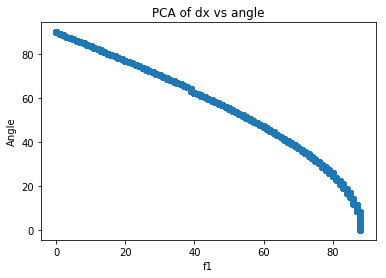

In [65]:
fig, ax = plt.subplots()
ax.scatter(X[:,0]  ,y)

ax.set( title = 'PCA of dx vs angle',
      xlabel = 'f1',
      ylabel= 'Angle')

[Text(0, 0.5, 'Angle'),
 Text(0.5, 0, 'f1'),
 Text(0.5, 1.0, 'PCA of dy vs angle')]

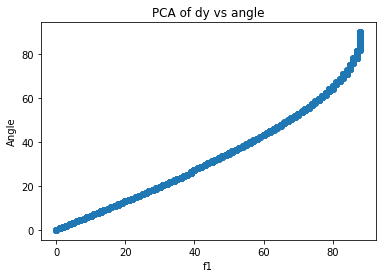

In [66]:
fig, ax = plt.subplots()
ax.scatter(X[:,1]  ,y)

ax.set( title = 'PCA of dy vs angle',
      xlabel = 'f1',
      ylabel= 'Angle')

## PCA with one component - Angle

In [60]:
pca = PCA(n_components=1)

Z = pca.fit_transform(X) # Z is 2-D
print(Z.shape)
print(y.shape)

(1000, 1)
(1000,)


[Text(0, 0.5, 'Angle'),
 Text(0.5, 0, 'f1'),
 Text(0.5, 1.0, 'PCA of data vs angle')]

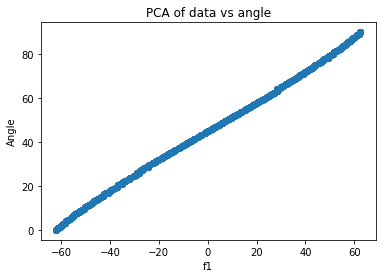

In [61]:
fig, ax = plt.subplots()
ax.scatter(Z  ,y)

ax.set( title = 'PCA of data vs angle',
      xlabel = 'f1',
      ylabel= 'Angle')

## PCA with two component - Angle

In [52]:
pca = PCA(n_components=2)

Z = pca.fit_transform(X) # Z is 2-D
print(Z.shape)
print(y.shape)

(1000, 2)
(1000,)


[Text(0, 0.5, 'Angle'),
 Text(0.5, 0, 'f1'),
 Text(0.5, 1.0, 'PCA of data vs angle')]

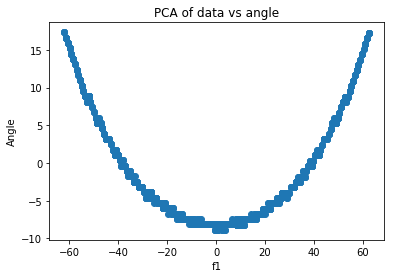

In [57]:
fig, ax = plt.subplots()
ax.scatter(Z[:,0] ,Z[:,1])

ax.set( title = 'PCA of data vs angle',
      xlabel = 'f1',
      ylabel= 'Angle')

In [55]:
Z[:,1]

array([ 8.0761633 ,  5.24934056,  1.05722434, -2.48271981,  1.0580263 ,
       -6.02426788, -6.75423055,  1.76553395,  8.0761633 ,  3.13082743,
        3.18135122, -8.15481048, 13.79556989, -8.15400851, -6.02426788,
       -8.1588203 , 12.38055459, -8.16283013,  8.0761633 , -3.19022746,
       -8.16363209, -7.46013427,  3.88885886, -3.93061566, 12.31559544,
       -8.86712992, -7.45772837, -3.19102942,  1.71741606,  3.13002547,
        6.71969143, -8.1612262 , -1.77360823, -6.75423055, -0.40109706,
       -8.1612262 , -8.15641441, 10.25803164, -3.93141763, 15.91809284,
       -3.93061566, -8.15481048, -3.93061566,  8.84221438, 17.26253524,
       -2.48271981, -8.86472402, -7.46013427, -8.15962227, -7.44329301,
       -1.10780275, -6.04912879,  5.30467613,  6.01138181, -8.15400851,
       -8.15561244, -7.45772837, -5.3424231 , -6.75342858, -3.89853707,
        4.59636651, -8.15481048, -4.60604472,  3.88885886, -1.06690254,
        0.30480666, 14.4357125 ,  2.42412175, -6.04832683, 10.96

## TRAINING

In [35]:
X= x_data
y= yAngle

In [36]:
# We need to ravel y,  e.g make (1000,)
yNp = yAngle.values
yNp = yNp.ravel()
print(type (yNp))
y =    yNp 
y.shape

<class 'numpy.ndarray'>


(1000,)

In [37]:
print(X.shape)
print(y.shape)

(1000, 2)
(1000,)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(750, 2) (250, 2) (750,) (250,)


In [39]:
# Flatten is done 
print( y_train.shape )
print(y_test.shape )
print( type (y_train ))


(750,)
(250,)
<class 'numpy.ndarray'>


In [40]:
# scale X_train to normalise the feature ranges
X_scaler = StandardScaler()
Z_train = X_scaler.fit_transform(X_train)

In [51]:
# Linear Regression using Gradient Descent

sgd_model = SGDRegressor(max_iter=1000, 
                     tol=1e-3,
                     random_state=8)

 
scores = cross_validate(sgd_model, Z_train, y_train, cv=5,
                        return_train_score=True,
                        return_estimator=True) # models
?SGDRegressor

In [42]:
# Get the W and bias for each fitted linear regressor
for m in scores['estimator']:
    print('W', m.coef_, 'bias', m.intercept_)

W [-13.4788592   13.08437164] bias [45.60360949]
W [-13.56964451  13.0369808 ] bias [45.6167731]
W [-13.45158793  13.0875307 ] bias [45.63005124]
W [-13.51395314  13.07600079] bias [45.57637784]
W [-13.38810138  13.19767984] bias [45.61546313]


In [43]:
# Score for test set (the 25% from train_test_split)
# Note that 'test_score' returned by cross_validate is actually
# 'validation score'. (easy to confuse)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

models = scores['estimator']

# Choose the best model
simple_angle_predictor = models[0]

# let's see the first model
Z_test = X_scaler.transform(X_test) # common mistake is to use
                                    # X_scaler.fit_transform
                                    # which will reset the scaler
y_pred = simple_angle_predictor.predict(Z_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred)) # scale-invariant

# PREVIOUS RUN
#MSE: 0.5173063540368755
#MAE: 0.5985518233919727
#R2: 0.9991722186754859

MSE: 0.5173063540368755
MAE: 0.5985518233919727
R2: 0.9991722186754859


In [44]:
print(y_test.shape)
print(y_pred.shape)

df_y_test = pd.DataFrame(y_test)
df_y_pred = pd.DataFrame(y_pred)

#y_test.head(10)
print( df_y_test.head(10))
print()
print( df_y_pred.head(10))

(250,)
(250,)
        0
0  30.860
1  17.020
2   5.773
3  19.050
4  12.945
5  66.300
6  39.970
7  22.520
8  57.380
9  73.800

           0
0  29.839882
1  16.683172
2   6.462920
3  18.631252
4  12.787011
5  66.973851
6  39.603225
7  22.041826
8  58.170209
9  74.320734


## Learning Curve

[Text(0, 0.5, 'R2'),
 Text(0.5, 0, 'Train size'),
 Text(0.5, 1.0, 'Learning curve')]

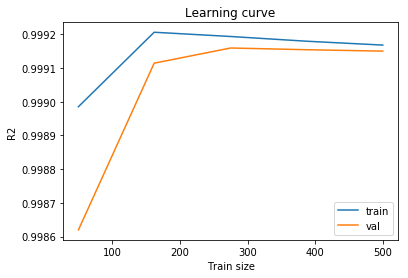

In [45]:
from sklearn.model_selection import learning_curve

# 5-fold cross validation to get learning curve R2 scores
# using default train_sizes
train_sizes, train_scores, val_scores = learning_curve(simple_angle_predictor,
                                                       Z_train, 
                                                       y_train, cv=3)

# plot learning curve:
#   plot train_scores vs. train_sizes
#   plot val_scores vs. train_sizes
# train_sizes is the number of training samples used for training

fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores.mean(axis=1),
        label='train') # average for 5-folds
ax.plot(train_sizes, val_scores.mean(axis=1),
        label='val')
ax.legend()
ax.set(title='Learning curve', xlabel='Train size', ylabel='R2')


## Saving the model

In [46]:
# save model and scaler for later use
pickle.dump(X_scaler, open('ascending_angle_predictor_X_scaler.pickle', 'wb'))
pickle.dump(simple_angle_predictor, open('ascending_angle_predictor.pickle', 'wb'))




## Prediction on a given image

In [47]:
import math
import scipy as sc

def LoadScalerModel():
    X_scaler = pickle.load(open('ascending_angle_predictor_X_scaler.pickle', 'rb'))
    model = pickle.load(open('ascending_angle_predictor.pickle', 'rb'))
    
    return X_scaler, model



###  For user

In [48]:
def PredictLineAngle():
    # We work with one image ( we extract two features)
    noOfImages =1
    dim = 100
    df_X = np.zeros((noOfImages, 2))

    # Load X_scaler and Model
    X_scaler, model = LoadScalerModel()
    
    # Extract image features


    dx,dy = ExtractImageFeatures( image, dim)
 

    # Store the extracted features 
    df_X[0,0]= dx
    df_X[0,1]= dy
 
    # let's see the first model
    df_Z = X_scaler.transform(df_X)  
                                    
    print("dx= {}, dy= {}".format(dx,dy))  
    
    y_pred = model.predict(df_Z )
    
    angle_predict = y_pred[0]
    # print('Angle predicted= {}'.format(angle_predict))
    
    return angle_predict

    

## MAIN PREDICT

### Input your image

C:\Users\admin\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


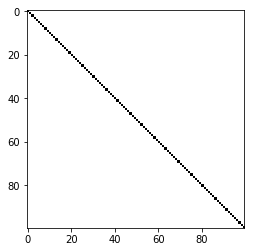

In [49]:
# Load image and display
image= sc.misc.imread("./TEST/test2.bmp", flatten= 1)
plt.imshow(image, cmap='gray') 

### Run the prediction

In [50]:
# Model is precise for ascending slopes, 
# but not for descending slopes

a= PredictLineAngle()
#print('Angle predicted= {}'.format(a))

# If need be rotate image and predict again
if a <0:
    RotateImage(image, dim)
    #plt.imshow(image, cmap='gray') 
    a= PredictLineAngle() * -1
    
print('Angle predicted= {}'.format(a))

dx= 99, dy= -99
dx= 99, dy= 99
Angle predicted= -44.76113858128957
